In [1]:
import cv2
import numpy as np
import os
import re
from scipy.ndimage import imread
from homography_estimation import util
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean
import random
import glob
%matplotlib inline


In [2]:
# Homography
boat_dir = "boat"

In [3]:
homography_file = open(os.path.join(boat_dir, "homography.txt"))

lines = homography_file.readlines()
correspondences = []

for line in lines:
    m = re.findall('(\d+), (\d+);', line)
    coords = []
    for coord in m:
        coords.append(map(int, coord))
    correspondences.append(coords)
    pass

correspondences[0] = np.array(correspondences[0])
correspondences[1] = np.array(correspondences[1])


In [4]:
homography = cv2.findHomography(correspondences[0], correspondences[1])[0]
print homography

[[  8.69678257e-01   2.28989567e-01   5.15663535e+00]
 [ -2.15323741e-01   8.73925018e-01   1.30535166e+02]
 [  5.45461425e-06   2.52106039e-05   1.00000000e+00]]


In [5]:
def normalized_dlt(x, x_tick):
    x_normalized = normalize(x)
    x_tick_normalized = normalize(x_tick)

    pass


def normalize(x):
    x_mean_center = x - np.mean(x, axis=0)
    average_distance = np.sqrt(np.mean(np.sum(x_mean_center**2, axis=1)))
    x_normalized = x_mean_center / average_distance * np.sqrt(2)
    return x_normalized


def construct_matrix_a(x_row, x_tick_row):
    pass


normalized_dlt(correspondences[0], correspondences[1])
# normalize:


In [6]:
img1 = imread(os.path.join(boat_dir, "img1+points.png"))
img2 = imread(os.path.join(boat_dir, "img2+points.png"))

In [7]:
# plt.figure(figsize=(20, 10))
# plt.subplot(1,2,1)
# plt.imshow(img1, cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(img2, cmap='gray')

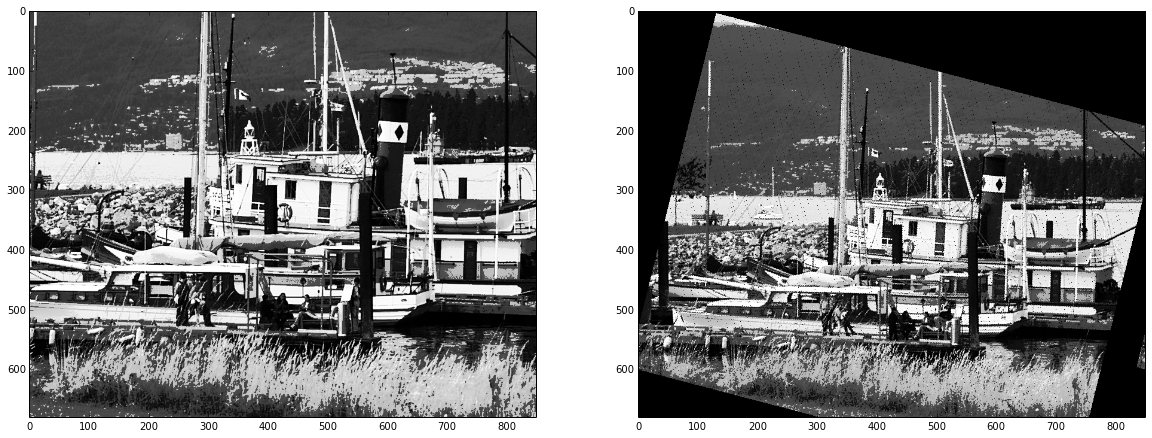

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
transformed_image = util.transform_image(img2, homography)
plt.imshow(transformed_image, cmap='gray')

In [9]:
def ransac(points1, points2, min_model_size=4, max_iteration=20):
    points1_norm = normalize(points1)
    points2_norm = normalize(points2)
    threshold = (np.std(points2) + np.std(points1))/2*5.99
    iteration_count = 0
    inliers = None
    while iteration_count < max_iteration:
        iteration_count += 1
        indices = []
        for _ in range(min_model_size):
            indices.append(random.randint(0, len(points1) - 1))
            pass
        model_minimum = cv2.findHomography(points1_norm[indices], points2_norm[indices])[0]
        indices = []
        for index in range(len(points1)):
            error = get_transfer_error(points1[index], points2[index], model_minimum)
            if error < threshold:
                indices.append(index)
                pass
            pass
        if len(indices) > 0.8*len(points1):
            inliers = indices
            break
        elif inliers is None or len(indices) > len(inliers):
            inliers = indices
            pass
        pass
    final_model = cv2.findHomography(points1_norm[inliers], points2_norm[inliers])[0]
    return final_model
    pass


def get_transfer_error(x_row, x_tick_row, homography):
    x_tick_cal = np.dot(homography, np.append(x_row, 1))[:2]
    x_cal = np.dot(np.linalg.inv(homography), np.append(x_tick_row, 1))
    x_cal = (x_cal/x_cal[2])[:2]
    error = np.sqrt(euclidean(x_row, x_cal)**2 + euclidean(x_tick_row, x_tick_cal)**2)
    return error


homography_ransac = ransac(correspondences[0], correspondences[1])

print homography_ransac
print homography

#print get_transfer_error(correspondences[0][0], correspondences[1][0], homography)


[[  9.74810184e-01   2.40078490e-01  -3.32971874e-04]
 [ -2.45248548e-01   9.71587584e-01   7.47653935e-04]
 [  2.34172602e-03  -8.60448605e-06   1.00000000e+00]]
[[  8.69678257e-01   2.28989567e-01   5.15663535e+00]
 [ -2.15323741e-01   8.73925018e-01   1.30535166e+02]
 [  5.45461425e-06   2.52106039e-05   1.00000000e+00]]


In [10]:
# Parallel length ratio problem
lines_straight = np.genfromtxt("PGPShelf/shelf0straightwithLinesPoints.csv", delimiter=",", usecols=(1, 2))
lines_rrstraight = np.genfromtxt("PGPShelf/shelfrrstraightwithLinesPoints.csv", delimiter=",", usecols=(1, 2))

def make_homog(point):
    if len(point) == 3:
        return point/point[-1]
    elif len(point) == 2:
        return np.append(point, 1)
    pass


In [11]:
b1 = make_homog(lines_straight[10])
t1 = make_homog(lines_straight[11])
b2 = make_homog(lines_straight[4])
t2 = make_homog(lines_straight[6])
horizon1 = make_homog(lines_straight[12])
horizon2 = make_homog(lines_straight[13])

In [12]:
horizon = make_homog(np.cross(horizon1, horizon2))
print "horizon: ", horizon
b1b2 = make_homog(np.cross(b1, b2))
print "b1b2: ", b1b2
u = make_homog(np.cross(b1b2, horizon))
print "vanishing point u: ", u

b1t1 = make_homog(np.cross(b1, t1))
b2t2 = make_homog(np.cross(b2, t2))
v = make_homog(np.cross(b1t1, b2t2))
print "vanishing point v: ", v

t1u = make_homog(np.cross(t1, u))
t1_tilda = make_homog(np.cross(t1u, b2t2))
print "t1~: ", t1_tilda

# distance from b2
t1_tilda_dist = [euclidean(t1_tilda, b2), 1]
t2_dist = [euclidean(t2, b2), 1]
v_dist = [euclidean(v, b2), 1]
print "distance from v to b2: ", v_dist[0]

# construct H
H = [[1, v_dist[0]], [0, 1]]
print "H: ", H

d1_d2_ratio = (t1_tilda_dist[0]*(v_dist[0] - t2_dist[0]))/(t2_dist[0]*(v_dist[0] - t1_tilda_dist[0]))
calculated_dist = 125/d1_d2_ratio

print "distance between 5 and 7: ", calculated_dist



horizon:  [ -0.00000000e+00  -9.54198473e-04   1.00000000e+00]
b1b2:  [  8.43046498e-06  -5.61577748e-04   1.00000000e+00]
vanishing point u:  [ -4.88070968e+04   1.04800000e+03   1.00000000e+00]
vanishing point v:  [  1.72766771e+03   5.68515633e+04   1.00000000e+00]
t1~:  [  2.30042665e+03   2.91618077e+02   1.00000000e+00]
distance from v to b2:  55039.3851141
H:  [[1, 55039.385114069162], [0, 1]]
distance between 5 and 7:  31.7421226447


In [13]:
# Camera calibration
chessboard_dir = "Camera_Calibration/"

height = 8
width = 6

termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((width*height, 3), np.float32)
objp[:, :2] = np.mgrid[:height, :width].T.reshape(-1, 2)

objpoints = []
imgpoints = []

gray = None
image_filenames = glob.glob(chessboard_dir + "IMAG*.jpg")
image_drawn = False

for filename in image_filenames:
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found_board, corners = cv2.findChessboardCorners(gray, (height, width), None)
    if found_board:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), termination_criteria)
        imgpoints.append(corners2)
        pass
    pass


In [14]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

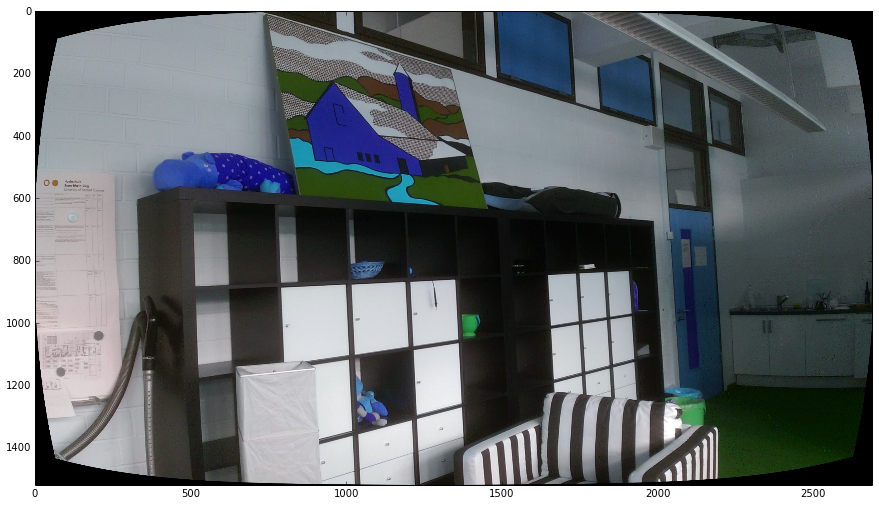

In [15]:
img_calib = cv2.imread("Camera_Calibration/image_test_calibration.jpg")
h, w = img.shape[:2]

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

img_undist = cv2.undistort(img_calib, mtx, dist, None, newcameramtx)

plt.figure(figsize=(15, 15))
plt.imshow(img_undist)


In [16]:
sift = cv2.xfeatures2d.SIFT_create()

In [28]:
img1 = cv2.imread("PGPShelf/20150616_074444.jpg", 0)
img2 = cv2.imread("PGPShelf/20150616_074411.jpg", 0)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

matcher = cv2.BFMatcher()

matches = matcher.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
        pass
    pass


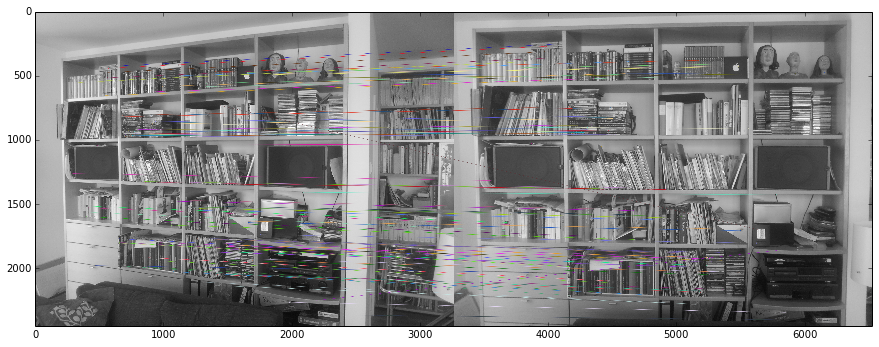

(<matplotlib.image.AxesImage at 0x7f7de4440e50>, None)

In [29]:
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(img3),plt.show()
